In [1]:
import pandas as pd

ddata = pd.read_csv("./data/ddata.txt", encoding="euc-kr", sep="\t", names=["num","speaker","contents","tags"])
mdata = pd.read_csv("./data/mdata.txt", encoding="euc-kr", sep="\t", names=["id","part","category","exptype","exp"])

ddata.head()

,num,speaker,contents,tags
0,0,<CO>,어서오세요. 코디봇입니다. 무엇을 도와드릴까요?,INTRO
1,1,<US>,처음 대학교 들어가는데 입을 옷 코디해주세요.,NaN
2,2,<CO>,신입생 코디에 어울리게 화사한 스웨터를 추천해드릴게요.,EXP_RES_SITUATION;EXP_RES_DESCRIPTION
3,3,<AC>,SW-009,NaN
4,4,<US>,이 옷에 어울리는 치마로 추천해주세요.,USER_SUCCESS


# 1. 전체 대화셋 개수 카운트

In [2]:
dial_num = 0

for i in range(1, len(ddata)):
    if ddata.loc[i, "num"] == 0:
        dial_num += 1
print("총 대화셋 수: ",dial_num)

총 대화셋 수:  7235


# 2. Mdata 합치기

## - Part 살려서 합치기

In [3]:
c_mdata = pd.DataFrame({"id":[0],"exp":[None]})
c_mdata.drop(0, axis=0, inplace=True)
c_mdata

,id,exp


In [4]:
id = ""
idx = 0
for i in range(len(mdata)):
    if id == mdata.loc[i, "id"]:
        c_mdata.loc[c_mdata.index[(c_mdata["id"] == id)].tolist().pop(),"exp"] = c_mdata.loc[c_mdata.index[(c_mdata["id"] == id)].tolist().pop(),"exp"] + " " + mdata.loc[i, "exp"]
    
    else:
        id = mdata.loc[i, "id"]
        c_mdata.loc[i, "id"] = id
        c_mdata.loc[i, "exp"] = mdata.loc[i, "exp"]

c_mdata.head()

,id,exp
0,BL-001,단추 여밈의 전체 오픈형 스탠드 칼라와 브이넥 네크라인의 결합스타일 손목까지 내려오...
20,BL-002,넓은 셔츠칼라 네크라인 앞중심에 반 오픈 끈여밈있는 스타일 드롭숄더 퍼프형 소매로 ...
38,BL-003,앞 중심에 단추 여밈 칼라가 없는 넓고 깊게 파인 브이넥 엉덩이 밑으로 내려오는 긴...
63,BL-004,"앞중심에 단추 여밈 칼라가 없는 라운드넥으로 골반 위에서 끝나는 짧은 기장 손목, ..."
84,BL-005,앞단추 여밈의 전체 오픈형 칼라가 없는 라운드넥크라인 엉덩이 위에서 끝나는 짧은 기...


In [5]:
for i in range(len(c_mdata)): # id 뒤에 공백 없애기
    c_mdata.iloc[i].id = c_mdata.iloc[i].id.strip()

print(c_mdata.iloc[0].id)
c_mdata.reset_index(drop=True,inplace=True)
c_mdata.head()

BL-001


,id,exp
0,BL-001,단추 여밈의 전체 오픈형 스탠드 칼라와 브이넥 네크라인의 결합스타일 손목까지 내려오...
1,BL-002,넓은 셔츠칼라 네크라인 앞중심에 반 오픈 끈여밈있는 스타일 드롭숄더 퍼프형 소매로 ...
2,BL-003,앞 중심에 단추 여밈 칼라가 없는 넓고 깊게 파인 브이넥 엉덩이 밑으로 내려오는 긴...
3,BL-004,"앞중심에 단추 여밈 칼라가 없는 라운드넥으로 골반 위에서 끝나는 짧은 기장 손목, ..."
4,BL-005,앞단추 여밈의 전체 오픈형 칼라가 없는 라운드넥크라인 엉덩이 위에서 끝나는 짧은 기...


# 3. NaN, Null 값 확인

In [6]:
ddata.drop(ddata.index[ddata.tags == "INTRO"].tolist(), axis=0, inplace=True)
ddata.reset_index(drop=True, inplace=True)
ddata[ddata.tags == "INTRO"]

,num,speaker,contents,tags


In [7]:
ddata.isnull().sum()

num             0
speaker         0
contents        0
tags        51927
dtype: int64

In [8]:
ddata.isna().sum()

num             0
speaker         0
contents        0
tags        51927
dtype: int64

In [9]:
ddata.fillna("", inplace=True)
ddata.isna().sum()

num         0
speaker     0
contents    0
tags        0
dtype: int64

In [10]:
mdata.isnull().sum()

id          0
part        0
category    0
exptype     0
exp         0
dtype: int64

In [11]:
c_mdata.isnull().sum()

id     0
exp    0
dtype: int64

# 4. 추천 성공 의상 아이디 종류 및 빈도 카운트 

## 한 번에 추천해도 실패하면 전부 실패로 달기

In [12]:
c_data = pd.DataFrame({"contents":[None], "id":["xx-xxx"]})
c_data.drop(0,axis=0,inplace=True)
c_data.head()

,contents,id


<코드 동작 원리>
<br>

대화문 하나씩 받아온 다음
- AC 태그 문장이면 일단 의상 변수에 저장,
- user_success 태그 문장이면

   - 변수에 저장된 의상이 하나면

      - 바로 대화문 변수랑 의상 변수 및 의상 메타데이터 합쳐서 저장 -> 레이블(id 컬럼에 저장)은 의상 코드가 됨

   - 변수에 저장된 의상의 여러 개면

      - 의상을 하나의 코드 단위로 쪼개서 대화문 변수랑 의상 메타데이터 합쳐서 저장
      
-  둘 다 아니고 일반 대화문이면 대화문 변수에 저장

In [13]:
dial = ddata.loc[0, "contents"].strip()
ac = ""

for i in range(1,len(ddata)):
    cur_sen = ddata.loc[i,"contents"].strip()

    if ddata.loc[i, "num"] > ddata.loc[i-1, "num"]: # 이전 대화셋에 포함된 문장인지 확인
        
        if ddata.loc[i,"speaker"] == "<AC>": # case 1. 의상 아이디가 나온 경우
            if len(ac) > 1:
                ac = ac + " " + cur_sen # 의상 아이디 저장
            else:
                ac = cur_sen

        elif "USER_SUCCESS" == ddata.loc[i,"tags"]: # case 2. USER_SUCCESS 태그가 나온 경우
            if 0 < len(ac) < 7: # 의상을 하나만 추천한 경우
                dial = dial + " " + ac + " " + cur_sen
                c_data.loc[i, "contents"] =  dial + " " + c_mdata.loc[c_mdata.id == ac].exp.values[0]
                c_data.loc[i, "id"] = ac
                ac = ""

            elif len(ac) == 0:
                dial = dial + " " + cur_sen

            else: # 의상을 한 번에 여러 개 추천한 경우
                idx_cnt = 0
                for one_ac in ac.split():
                    c_data.loc[i + idx_cnt, "contents"] =  dial + " " + one_ac + " "+ cur_sen + " " + c_mdata.loc[c_mdata.id == one_ac].exp.values[0]
                    c_data.loc[i + idx_cnt, "id"] = one_ac
                    idx_cnt += 1
                dial = dial + " " + ac + " " + cur_sen    
                ac = ""
        
        elif "USER_FAIL" in ddata.loc[i,"tags"]:
            dial = dial + " " + ac + " " + cur_sen
            ac = ""

        else: # case 3. 그냥 대화문인 경우
            dial = dial + " " + cur_sen
    
    else: #새로운 대화셋 시작이면 초기화
        dial = cur_sen
        ac = ""

In [14]:
print("전체 데이터 수: ", len(c_data))
c_data.head()

전체 데이터 수:  34303


,contents,id
3,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SW-009
12,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SK-053
17,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,CT-019
22,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SE-039
26,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,CT-019


In [15]:
c_data.reset_index(drop=True ,inplace=True)
c_data.head()

,contents,id
0,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SW-009
1,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SK-053
2,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,CT-019
3,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SE-039
4,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,CT-019


In [16]:
c_data.loc[0].contents

'처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터를 추천해드릴게요. SW-009 이 옷에 어울리는 치마로 추천해주세요. 라운드 네크라인 여밈이 없는 풀오버 스타일 전체 케이블 조직 드롭숄더 슬리브 손등까지 오는 길이의 소매 몸에 적당히 맞는 품 엉덩이를 살짝 덮는 길이 네크라인, 소매 끝, 밑단에 고무단 처리 레이온52%,나일론20%,폴리에스터28% 꽈배기 조직, 플레인 조직이 섞여 있는 형태 드라이 크리닝 단색의 라임색 브라이트톤(고명도 고채도)의 옐로우 그린 산뜻하고 발랄한 느낌 기본의 단정한 편안한 산뜻한 발랄한 경쾌한 따뜻한 데일리룩 캠퍼스룩'

In [17]:
sk_data = pd.DataFrame({"contents":[None], "id":["xx-xxx"]})
sk_data.drop(0,axis=0,inplace=True)
sk_data.head()

,contents,id


In [18]:
for i in range(len(c_data)):
    if "SK" in c_data["id"][i][0:2]:
        sk_data = sk_data.append(c_data.iloc[i])

sk_data.reset_index(drop=True, inplace=True)
print("데이터 개수",len(sk_data))
sk_data.head()

데이터 개수 2500


,contents,id
0,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SK-053
1,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SK-053
2,데이트 갈 건데 코디부탁합니다. 화사한 꽃무늬 블라우스가 돋보이는 코디입니다. 마음...,SK-082
3,추석에 할머니댁 가는데 깔끔한 옷 추천해주세요. 가을 분위기를 내는 아우터에 포멀한...,SK-061
4,카페에 알바를 가려고 하는데 면접 복장을 추천해주세요. 여름 옷으로 보여주세요. 네...,SK-048


In [19]:
sk_data["contents"] = sk_data["contents"].str.replace("[^A-Za-z0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
sk_data.head()

<ipython-input-19-b3f752366706>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  sk_data["contents"] = sk_data["contents"].str.replace("[^A-Za-z0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,contents,id
0,처음 대학교 들어가는데 입을 옷 코디해주세요 신입생 코디에 어울리게 화사한 스웨터를...,SK-053
1,처음 대학교 들어가는데 입을 옷 코디해주세요 신입생 코디에 어울리게 화사한 스웨터를...,SK-053
2,데이트 갈 건데 코디부탁합니다 화사한 꽃무늬 블라우스가 돋보이는 코디입니다 마음에 ...,SK-082
3,추석에 할머니댁 가는데 깔끔한 옷 추천해주세요 가을 분위기를 내는 아우터에 포멀한 ...,SK-061
4,카페에 알바를 가려고 하는데 면접 복장을 추천해주세요 여름 옷으로 보여주세요 네 그...,SK-048


In [20]:
sk_data["id"] = sk_data["id"].str.replace("[^0-9]","")

sk_data.head()

<ipython-input-20-8c58e4c007a4>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  sk_data["id"] = sk_data["id"].str.replace("[^0-9]","")


,contents,id
0,처음 대학교 들어가는데 입을 옷 코디해주세요 신입생 코디에 어울리게 화사한 스웨터를...,053
1,처음 대학교 들어가는데 입을 옷 코디해주세요 신입생 코디에 어울리게 화사한 스웨터를...,053
2,데이트 갈 건데 코디부탁합니다 화사한 꽃무늬 블라우스가 돋보이는 코디입니다 마음에 ...,082
3,추석에 할머니댁 가는데 깔끔한 옷 추천해주세요 가을 분위기를 내는 아우터에 포멀한 ...,061
4,카페에 알바를 가려고 하는데 면접 복장을 추천해주세요 여름 옷으로 보여주세요 네 그...,048


In [21]:
from collections import Counter
temp = sk_data["id"].tolist()
type_count = dict(Counter(temp))
type_count

{'053': 26,
 '082': 28,
 '061': 8,
 '048': 25,
 '055': 13,
 '014': 10,
 '034': 31,
 '027': 9,
 '100': 3,
 '062': 20,
 '072': 16,
 '043': 38,
 '091': 5,
 '099': 21,
 '081': 3,
 '073': 13,
 '085': 140,
 '092': 21,
 '087': 7,
 '023': 13,
 '080': 17,
 '059': 23,
 '095': 8,
 '069': 28,
 '002': 18,
 '010': 38,
 '012': 10,
 '001': 30,
 '063': 10,
 '044': 17,
 '084': 52,
 '052': 13,
 '047': 22,
 '035': 12,
 '097': 10,
 '086': 7,
 '060': 10,
 '009': 47,
 '096': 17,
 '016': 8,
 '078': 13,
 '041': 53,
 '089': 10,
 '049': 13,
 '031': 20,
 '064': 16,
 '051': 20,
 '037': 13,
 '021': 12,
 '065': 20,
 '033': 15,
 '005': 12,
 '019': 12,
 '032': 26,
 '071': 9,
 '026': 16,
 '046': 8,
 '090': 7,
 '056': 11,
 '020': 38,
 '075': 2,
 '068': 15,
 '015': 3,
 '006': 18,
 '076': 4,
 '070': 8,
 '067': 18,
 '058': 18,
 '088': 8,
 '093': 5,
 '066': 6,
 '074': 8,
 '038': 36,
 '042': 8,
 '018': 4,
 '098': 4,
 '045': 14,
 '083': 27,
 '003': 13,
 '040': 4,
 '022': 7,
 '039': 18,
 '057': 8,
 '024': 2,
 '004': 8,
 '011':

In [22]:
len(type_count)

223

In [23]:
del_list = []
for i in type_count.keys():
    if type_count.get(i) == 1:
        del_list.append(i)
del_list

['050', '153', '188', '142', '170', '229', '193', '182', '191']

In [24]:
sk_data.head()

,contents,id
0,처음 대학교 들어가는데 입을 옷 코디해주세요 신입생 코디에 어울리게 화사한 스웨터를...,053
1,처음 대학교 들어가는데 입을 옷 코디해주세요 신입생 코디에 어울리게 화사한 스웨터를...,053
2,데이트 갈 건데 코디부탁합니다 화사한 꽃무늬 블라우스가 돋보이는 코디입니다 마음에 ...,082
3,추석에 할머니댁 가는데 깔끔한 옷 추천해주세요 가을 분위기를 내는 아우터에 포멀한 ...,061
4,카페에 알바를 가려고 하는데 면접 복장을 추천해주세요 여름 옷으로 보여주세요 네 그...,048


In [25]:
for i in del_list:
    sk_data = sk_data[sk_data["id"] != i]

In [26]:
len(sk_data)

2491

In [27]:
sk_data.reset_index(drop=True, inplace=True)

In [28]:
import matplotlib.pyplot as plt
plt.bar(Counter(sk_data.id).keys(),Counter(sk_data.id).values(), color='k')

<BarContainer object of 214 artists>

# 5. 형태소 분석

## Mecab 사용

In [30]:
from konlpy.tag import Mecab
mecab = Mecab()

In [31]:
mecab.morphs(sk_data["contents"][0])

['처음',
 '대학교',
 '들어가',
 '는',
 '데',
 '입',
 '을',
 '옷',
 '코디',
 '해',
 '주',
 '세요',
 '신입',
 '생',
 '코디',
 '에',
 '어울리',
 '게',
 '화사',
 '한',
 '스웨터',
 '를',
 '추천',
 '해',
 '드릴게요',
 'SW',
 '009',
 '이',
 '옷',
 '에',
 '어울리',
 '는',
 '치마',
 '로',
 '추천',
 '해',
 '주',
 '세요',
 '고객',
 '님',
 '의',
 '키',
 '사이즈',
 '에',
 '맞추',
 '면',
 '이런',
 '옷',
 '도',
 '잘',
 '어울리',
 '실',
 '것',
 '같',
 '은',
 '데',
 '어떠신가요',
 'SK',
 '016',
 '제',
 '가',
 '키',
 '가',
 '작',
 '아서',
 '짧',
 '은',
 '치마',
 '로',
 '추천',
 '해',
 '주',
 '세요',
 '상',
 '의',
 '색상',
 '과',
 '도',
 '매칭',
 '이',
 '잘',
 '어울리',
 '는',
 '짧',
 '은',
 '치마',
 '입니다',
 'SK',
 '052',
 '어두운',
 '계열',
 '은',
 '없',
 '나요',
 '언밸런스',
 '한',
 '컷팅',
 '으로',
 '세련미',
 '를',
 '돋보이',
 '게',
 '하',
 '는',
 '치마',
 '인데',
 '마음',
 '에',
 '드',
 '시',
 '나요',
 'SK',
 '053',
 '나쁘',
 '지',
 '않',
 '네요',
 '외투',
 '도',
 '추천',
 '해',
 '주',
 '시',
 '겠',
 '어요',
 '오른쪽',
 '허벅지',
 '중간',
 '에서',
 '왼쪽',
 '무릎',
 '위',
 '사선',
 '으로',
 '내려오',
 '는',
 '길',
 '이',
 '폭',
 '좁',
 '은',
 'A',
 '라인',
 '실루엣',
 '허벅지',
 '위쪽',
 '에서',
 '절개',
 '되',
 '어',
 

In [32]:
len(sk_data)

2491

In [33]:
x_data = []
for i in range(len(sk_data)):
    x_data.append(mecab.morphs(sk_data["contents"][i]))

x_data[0]

['처음',
 '대학교',
 '들어가',
 '는',
 '데',
 '입',
 '을',
 '옷',
 '코디',
 '해',
 '주',
 '세요',
 '신입',
 '생',
 '코디',
 '에',
 '어울리',
 '게',
 '화사',
 '한',
 '스웨터',
 '를',
 '추천',
 '해',
 '드릴게요',
 'SW',
 '009',
 '이',
 '옷',
 '에',
 '어울리',
 '는',
 '치마',
 '로',
 '추천',
 '해',
 '주',
 '세요',
 '고객',
 '님',
 '의',
 '키',
 '사이즈',
 '에',
 '맞추',
 '면',
 '이런',
 '옷',
 '도',
 '잘',
 '어울리',
 '실',
 '것',
 '같',
 '은',
 '데',
 '어떠신가요',
 'SK',
 '016',
 '제',
 '가',
 '키',
 '가',
 '작',
 '아서',
 '짧',
 '은',
 '치마',
 '로',
 '추천',
 '해',
 '주',
 '세요',
 '상',
 '의',
 '색상',
 '과',
 '도',
 '매칭',
 '이',
 '잘',
 '어울리',
 '는',
 '짧',
 '은',
 '치마',
 '입니다',
 'SK',
 '052',
 '어두운',
 '계열',
 '은',
 '없',
 '나요',
 '언밸런스',
 '한',
 '컷팅',
 '으로',
 '세련미',
 '를',
 '돋보이',
 '게',
 '하',
 '는',
 '치마',
 '인데',
 '마음',
 '에',
 '드',
 '시',
 '나요',
 'SK',
 '053',
 '나쁘',
 '지',
 '않',
 '네요',
 '외투',
 '도',
 '추천',
 '해',
 '주',
 '시',
 '겠',
 '어요',
 '오른쪽',
 '허벅지',
 '중간',
 '에서',
 '왼쪽',
 '무릎',
 '위',
 '사선',
 '으로',
 '내려오',
 '는',
 '길',
 '이',
 '폭',
 '좁',
 '은',
 'A',
 '라인',
 '실루엣',
 '허벅지',
 '위쪽',
 '에서',
 '절개',
 '되',
 '어',
 

In [34]:
stopwords = []
with open('./data/불용어사전.txt', mode='rt', encoding='utf-8') as f:
    for word in f.readlines():
        word = word.strip()
        stopwords.append(word)
stopwords[0:2]

['어찌됐든', '그위에']

In [35]:
X_data = []
for sentence in x_data: #문장 하나 가져오고 단어 단위로 쪼개기
    temp_X = [word for word in sentence if not word in stopwords] # 불용어 제거
    X_data.append(temp_X)
X_data[0]

['처음',
 '대학교',
 '들어가',
 '데',
 '입',
 '옷',
 '코디',
 '주',
 '세요',
 '신입',
 '생',
 '코디',
 '어울리',
 '게',
 '화사',
 '스웨터',
 '추천',
 '드릴게요',
 'SW',
 '009',
 '옷',
 '어울리',
 '치마',
 '추천',
 '주',
 '세요',
 '고객',
 '님',
 '키',
 '사이즈',
 '맞추',
 '면',
 '옷',
 '도',
 '잘',
 '어울리',
 '실',
 '같',
 '데',
 '어떠신가요',
 'SK',
 '016',
 '키',
 '작',
 '아서',
 '짧',
 '치마',
 '추천',
 '주',
 '세요',
 '상',
 '색상',
 '도',
 '매칭',
 '잘',
 '어울리',
 '짧',
 '치마',
 '입니다',
 'SK',
 '052',
 '어두운',
 '계열',
 '나요',
 '언밸런스',
 '컷팅',
 '세련미',
 '돋보이',
 '게',
 '치마',
 '인데',
 '마음',
 '시',
 '나요',
 'SK',
 '053',
 '나쁘',
 '지',
 '않',
 '네요',
 '외투',
 '도',
 '추천',
 '주',
 '시',
 '겠',
 '어요',
 '오른쪽',
 '허벅지',
 '중간',
 '왼쪽',
 '무릎',
 '위',
 '사선',
 '내려오',
 '길',
 '폭',
 '좁',
 'A',
 '라인',
 '실루엣',
 '허벅지',
 '위쪽',
 '절개',
 '되',
 '밑단',
 '좌우',
 '양쪽',
 '플리츠',
 '주름',
 '있',
 '허리',
 '왼쪽',
 '지퍼',
 '밈',
 '오른쪽',
 '왼쪽',
 '길',
 '지',
 '언밸런스',
 '밑단',
 '앞',
 '뒤',
 '면',
 '허리',
 '라인',
 '양쪽',
 '다트',
 '폴리에스테르',
 '97',
 '스판덱스',
 '3',
 '차갑',
 '고',
 '매끈',
 '함',
 '신축성',
 '두께',
 '감',
 '보통',
 '비침',
 '손세탁',
 '미온수',
 '세탁',
 

## 1. 임베딩 레이어 활용

### 정수 인코딩

In [36]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)

In [37]:
threshold = 6
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 3835
등장 빈도가 5번 이하인 희귀 단어의 수: 1623
단어 집합에서 희귀 단어의 비율: 42.32073011734029
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.8975760207213546


In [38]:
vocab_size = total_cnt - rare_cnt + 1 # tokenizer 함수에 들어 갈 때 영향줘서 1 추가 해야 됨
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 2213


케라스 토크나이저의 정수 인코딩은 인덱스가 1부터 시작하지만,

케라스 원-핫 인코딩에서 배열의 인덱스가 0부터 시작하기 때문에

배열의 크기를 실제 단어 집합의 크기보다 +1로 생성해야하므로 미리 +1 선언 

### 맨 앞자리는 비어있어야 함 (원 핫 인코딩은 정수 인코딩한 뒤 나오는 정수 값 자리에 1을 넣는 것)

In [39]:
tokenizer = Tokenizer(num_words=vocab_size - 1)
tokenizer.fit_on_texts(X_data)
len(tokenizer.word_index)

3835

In [40]:
X_data = tokenizer.texts_to_sequences(X_data) # 단어에 정수 붙여줄 때 num_word 적용

위에서 num_words는 이 데이터에서 등장 빈도 순위로 몇 번째에 해당하는 단어까지만 사용할 것인지 조절

예를 들어서 100이란 값을 넣으면, 등장 빈도 순위가 1~100에 해당하는 단어만 사용

In [41]:
X_data[1]

[1633,
 1634,
 928,
 281,
 26,
 50,
 3,
 1,
 2,
 2107,
 3,
 40,
 66,
 240,
 302,
 13,
 469,
 168,
 343,
 50,
 40,
 14,
 13,
 1,
 2,
 147,
 137,
 539,
 680,
 1735,
 51,
 50,
 24,
 80,
 40,
 374,
 34,
 281,
 48,
 8,
 470,
 539,
 507,
 434,
 172,
 14,
 13,
 1,
 2,
 330,
 41,
 24,
 511,
 80,
 40,
 172,
 14,
 16,
 8,
 811,
 391,
 435,
 23,
 340,
 1544,
 430,
 66,
 14,
 459,
 7,
 20,
 23,
 8,
 635,
 1205,
 94,
 114,
 37,
 255,
 24,
 13,
 1,
 20,
 30,
 17,
 522,
 1863,
 181,
 350,
 98,
 1162,
 77,
 18,
 367,
 774,
 309,
 66,
 5,
 115,
 84,
 384,
 774,
 13,
 1,
 2,
 1334,
 41,
 748,
 66,
 80,
 202,
 384,
 16,
 112,
 596,
 44,
 24,
 13,
 1,
 2,
 1208,
 140,
 229,
 453,
 157,
 20,
 23,
 762,
 691,
 13,
 1,
 2,
 27,
 24,
 748,
 66,
 80,
 40,
 607,
 70,
 16,
 22,
 536,
 415,
 37,
 52,
 3,
 1736,
 1335,
 101,
 5,
 23,
 1113,
 2108,
 944,
 70,
 52,
 3,
 1736,
 2108,
 404,
 7,
 20,
 23,
 8,
 635,
 7,
 37,
 241,
 189,
 74,
 108,
 56,
 49,
 99,
 272,
 105,
 21,
 333,
 381,
 57,
 19,
 54,
 74,
 324,
 22

문장 최대 길이 : 475
문장의 평균 길이 : 159.43115214773184


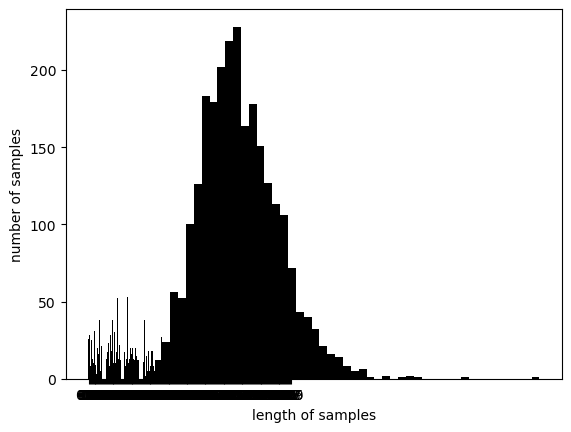

In [42]:
print('문장 최대 길이 :',max(len(l) for l in X_data))
print('문장의 평균 길이 :',sum(map(len, X_data))/len(X_data))
plt.hist([len(s) for s in X_data], bins=50, color='k')
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
plt.close()

In [43]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 300
below_threshold_len(max_len, X_data)

전체 샘플 중 길이가 300 이하인 샘플의 비율: 99.63869931754316


## padding

In [44]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_data = pad_sequences(X_data, maxlen = max_len)

In [45]:
print(len(X_data[1]))
X_data[1]

300


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0, 1633, 1634,  928,  281,
         26,   50,    3,    1,    2, 2107,    3,   40,   66,  240,  302,
         13,  469,  168,  343,   50,   40,   14,   13,    1,    2,  147,
        137,  539,  680, 1735,   51,   50,   24,   80,   40,  374,   34,
        281,   48,    8,  470,  539,  507,  434,  172,   14,   13,    1,
          2,  330,   41,   24,  511,   80,   40,  172,   14,   16,    8,
        811,  391,  435,   23,  340, 1544,  430,   66,   14,  459,    7,
         20,   23,    8,  635, 1205,   94,  114,   37,  255,   24,   13,
          1,   20,   30,   17,  522, 1863,  181,  3

# 6. LSTM 돌리기 

In [46]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [47]:
X = X_data
y = sk_data.id.tolist()

In [48]:
X[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0, 1633, 1634,  928,  281,
         26,   50,    3,    1,    2, 2107,    3,   40,   66,  240,  302,
         13,  469,  168,  343,   50,   40,   14,   13,    1,    2,  147,
        137,  539,  680, 1735,   51,   50,   24,   80,   40,  374,   34,
        281,   48,    8,  470,  539,  507,  434,  172,   14,   13,    1,
          2,  330,   41,   24,  511,   80,   40,  172,   14,   16,    8,
        811,  391,  435,   23,  340, 1544,  430,   66,   14,  459,    7,
         20,   23,    8,  635, 1205,   94,  114,   37,  255,   24,   13,
          1,   20,   30,   17,  522, 1863,  181,  3

In [49]:
y[1]

'053'

In [50]:
print(len(X),len(y))

2491 2491


In [51]:
y = to_categorical(y)

In [52]:
print(X.shape, y.shape)

(2491, 300) (2491, 231)


In [53]:
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=777, stratify=y) #추천 한 번밖에 안된 애들 있어서 stratify 안됨

In [54]:
num_class = int(max(sk_data.id)) + 1

In [55]:
from tensorflow.keras.layers import LSTM

In [56]:
model = Sequential()
model.add(Embedding(vocab_size, max_len))
model.add(LSTM(max_len))
model.add(Dense(num_class, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         663900    
_________________________________________________________________
lstm (LSTM)                  (None, 300)               721200    
_________________________________________________________________
dense (Dense)                (None, 231)               69531     
Total params: 1,454,631
Trainable params: 1,454,631
Non-trainable params: 0
_________________________________________________________________


In [57]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
mc = ModelCheckpoint('sk_model_lstm.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [58]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, callbacks=[es, mc], batch_size=32, validation_split=0.2)

print("테스트 셋 체크")
loaded_model = load_model('sk_model_lstm.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

Epoch 1/10
44/44 [==============================] - 145s 3s/step - loss: 5.2527 - acc: 0.0954 - val_loss: 4.4663 - val_acc: 0.0802

Epoch 00001: val_acc improved from -inf to 0.08023, saving model to sk_model_lstm.h5
Epoch 2/10
44/44 [==============================] - 161s 4s/step - loss: 3.9681 - acc: 0.1802 - val_loss: 2.8816 - val_acc: 0.4413

Epoch 00002: val_acc improved from 0.08023 to 0.44126, saving model to sk_model_lstm.h5
Epoch 3/10
44/44 [==============================] - 130s 3s/step - loss: 2.1729 - acc: 0.5669 - val_loss: 1.7007 - val_acc: 0.7077

Epoch 00003: val_acc improved from 0.44126 to 0.70774, saving model to sk_model_lstm.h5
Epoch 4/10
44/44 [==============================] - 167s 4s/step - loss: 1.0262 - acc: 0.8210 - val_loss: 0.9038 - val_acc: 0.8625

Epoch 00004: val_acc improved from 0.70774 to 0.86246, saving model to sk_model_lstm.h5
Epoch 5/10
44/44 [==============================] - 92s 2s/step - loss: 0.4004 - acc: 0.9400 - val_loss: 0.5534 - val_acc: 

Cannot convert a symbolic Tensor -> numpy 버전 1.19.5로 바꿔줌

https://wikidocs.net/45101

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


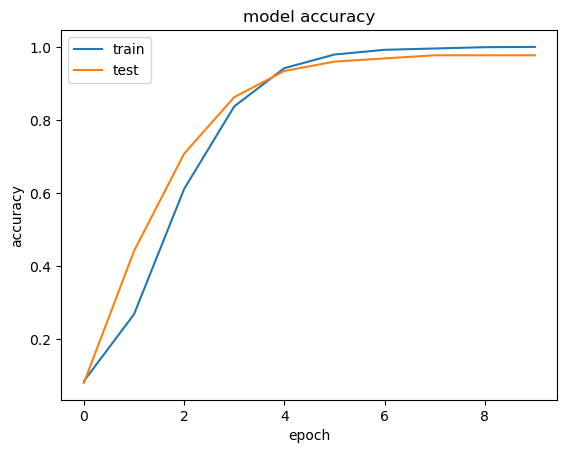

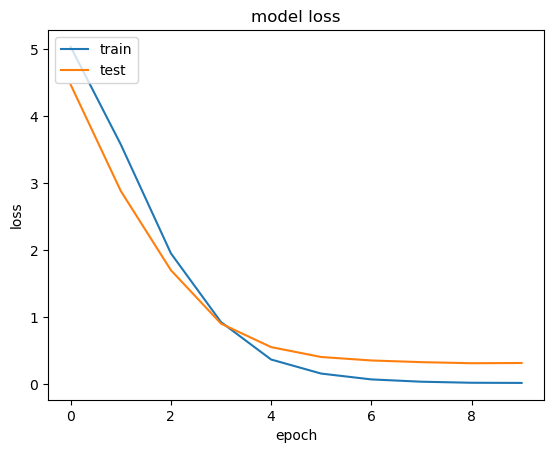

In [59]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()